<div class="alert alert-block alert-info">
<b>How to run this notebook?</b><br />
<ol>
    <li>Install the DockStream environment: conda env create -f environment.yml in the DockStream directory</li>
    <li>Activate the environment: conda activate DockStreamCommunity</li>
    <li>Execute jupyter: jupyter notebook</li>
    <li> Copy the link to a browser</li>
    <li> Update variables <b>dockstream_path</b> and <b>dockstream_env</b> (the path to the environment DockStream) in the 
        first code block below</li>
    </ol>
</div>

<div class="alert alert-block alert-warning">
    <b>Caution:</b>
    Make sure, you have the AutoDock Vina binary available somewhere.
</div>

# `AutoDock Vina` backend demo
This notebook will demonstrate how to **(a)** set up a `AutoDock Vina` backend run with `DockStream`, including the most important settings and **(b)** how to set up a `REINVENT` run with `AutoDock` docking enabled as one of the scoring function components.

**Steps:**
* a: Set up `DockStream` run
  1. Prepare the receptor
  2. Prepare the input: SMILES and configuration file (JSON format)
  3. Execute the docking and parse the results
* b: Set up `REINVENT` run with a `DockStream` component
  1. Prepare the receptor (see *a.1*)
  2. Prepare the input (see *a.2*)
  3. Prepare the `REINVENT` configuration (JSON format)
  4. Execute `REINVENT`

The following imports / loadings are only necessary when executing this notebook. If you want to use `DockStream` directly from the command-line, it is enough to execute the following with the appropriate configurations:

```
conda activate DockStream
python /path/to/DockStream/target_preparator.py -conf target_prep.json
python /path/to/DockStream/docker.py -conf docking.json
```

In [1]:
import os
import json
import tempfile

# update these paths to reflect your system's configuration
dockstream_path = os.path.expanduser("~/Desktop/ProjectData/DockStream")
dockstream_env = os.path.expanduser("~/miniconda3/envs/DockStream")
vina_binary_location = os.path.expanduser("~/Desktop/ProjectData/foreign/AutoDockVina/autodock_vina_1_1_2_linux_x86/bin")

# no changes are necessary beyond this point
# ---------
# get the notebook's root path
try: ipynb_path
except NameError: ipynb_path = os.getcwd()

# generate the paths to the entry points
target_preparator = dockstream_path + "/target_preparator.py"
docker = dockstream_path + "/docker.py"

# generate a folder to store the results
output_dir = os.path.expanduser("~/Desktop/AutoDock_Vina_demo")
try:
    os.mkdir(output_dir)
except FileExistsError:
    pass

In [2]:
# generate the paths to the files shipped with this implementation
apo_1UYD_path = ipynb_path + "/../data/1UYD/1UYD_apo.pdb"
reference_ligand_path = ipynb_path + "/../data/1UYD/PU8.pdb"
smiles_path = ipynb_path + "/../data/1UYD/ligands_smiles.txt"

# generate output paths for the configuration file, the "fixed" PDB file and the "Gold" receptor
target_prep_path = output_dir + "/ADV_target_prep.json"
fixed_pdb_path = output_dir + "/ADV_fixed_target.pdb"
adv_receptor_path = output_dir + "/ADV_receptor.pdbqt"
log_file_target_prep = output_dir + "/ADV_target_prep.log"
log_file_docking = output_dir + "/ADV_docking.log"

# generate output paths for the configuration file, embedded ligands, the docked ligands and the scores
docking_path = output_dir + "/ADV_docking.json"
ligands_conformers_path = output_dir + "/ADV_embedded_ligands.sdf"
ligands_docked_path = output_dir + "/ADV_ligands_docked.sdf"
ligands_scores_path = output_dir + "/ADV_scores.csv"

## Target preparation
`AutoDock Vina` uses the `PDBQT` format for both the receptors and the (individual ligands). First, we will generate the receptor into which we want to dock the molecules. This is a semi-automated process and while `DockStream` has an entry point to help you setting this up, it might be wise to think about the details of this process beforehand, including:
* Is my target structure complete (e.g. has it missing loops in the area of interest)?
* Do I have a reference ligand in a complex (holo) structure or do I need to define the binding cleft (cavity) in a different manner?
* Do I want to keep the crystal water molecules, potential co-factors and such or not?

This step has to be done once per project and target. Typically, we start from a PDB file with a holo-structure, that is, a protein with its ligand. Using a holo-structure as input is convenient for two reasons:
1. The cavity can be specified as being a certain area around the ligand in the protein (assuming the binding mode does not change too much).
2. One can align other ligands (often a series with considerable similarity is used in docking studies) to the "reference ligand", potentially improving the performance.

![](img/target_preparation_template_method.png)

For this notebook, it is assumed that you are able to

1. download `1UYD` and
2. split it into `1UYD_apo.pdb` and `reference_ligand.pdb` (name is `PU8` in the file), respectively.

We will now set up the JSON instruction file for the target preparator that will help us build a receptor suitable for `AutoDock Vina` docking later. We will also include a small section (internally using [PDBFixer](https://github.com/openmm/pdbfixer)) that will take care of minor problems of the input structure, such as missing hetero atoms - but of course you can address these things with a program of your choice as well. We will write the JSON to the output folder in order to load it with the `target_preparator.py` entry point of `DockStream`.

Note, that we can use the (optional) `extract_box` block in the configuration to specify the cavity's box (the area where the algorithm will strive to optimize the poses). For this we simply specify a reference ligand and the algorithm will extract the center-of-geometry and the minimum and maximum values for all three axes. This information is printed to the log file and can be used to specify the cavity in the docking step.

In [3]:
# specify the target preparation JSON file as a dictionary and write it out
tp_dict = {
  "target_preparation":
  {
    "header": {                                   # general settings
      "logging": {                                # logging settings (e.g. which file to write to)
        "logfile": log_file_target_prep
      }
    },
    "input_path": apo_1UYD_path,                  # this should be an absolute path
    "fixer": {                                    # based on "PDBFixer"; tries to fix common problems with PDB files
      "enabled": True,
      "standardize": True,                        # enables standardization of residues
      "remove_heterogens": True,                  # remove hetero-entries
      "fix_missing_heavy_atoms": True,            # if possible, fix missing heavy atoms
      "fix_missing_hydrogens": True,              # add hydrogens, which are usually not present in PDB files
      "fix_missing_loops": False,                 # add missing loops; CAUTION: the result is usually not sufficient
      "add_water_box": False,                     # if you want to put the receptor into a box of water molecules
      "fixed_pdb_path": fixed_pdb_path            # if specified and not "None", the fixed PDB file will be stored here
    },
    "runs": [                                     # "runs" holds a list of backend runs; at least one is required
      {
        "backend": "AutoDockVina",                # one of the backends supported ("AutoDockVina", "OpenEye", ...)
        "output": {
          "receptor_path": adv_receptor_path      # the generated receptor file will be saved to this location
        },
        "parameters": {
          "pH": 7.4,                              # sets the protonation states (NOT used in Vina)
          "extract_box": {                        # in order to extract the coordinates of the pocket (see text)
            "reference_ligand_path": reference_ligand_path,   # path to the reference ligand
            "reference_ligand_format": "PDB"                  # format of the reference ligand
          }
}}]}}

with open(target_prep_path, 'w') as f:
    json.dump(tp_dict, f, indent="    ")

In [4]:
# execute this in a command-line environment after replacing the parameters
!{dockstream_env}/bin/python {target_preparator} -conf {target_prep_path}
!head -n 25 {adv_receptor_path}

REMARK  Name = /tmp/tmponfdi39q.pdb
REMARK                            x       y       z     vdW  Elec       q    Type
REMARK                         _______ _______ _______ _____ _____    ______ ____
ATOM      1  N   GLU A   1       6.484  28.442  39.441  0.00  0.00    +0.386 N 
ATOM      2  CA  GLU A   1       7.718  28.546  38.611  0.00  0.00    -0.005 C 
ATOM      3  C   GLU A   1       7.625  27.706  37.277  0.00  0.00    +0.199 C 
ATOM      4  O   GLU A   1       7.333  26.478  37.304  0.00  0.00    -0.278 OA
ATOM      5  CB  GLU A   1       8.951  28.140  39.474  0.00  0.00    -0.048 C 
ATOM      6  CG  GLU A   1       9.355  26.647  39.367  0.00  0.00    +0.048 C 
ATOM      7  CD  GLU A   1      10.138  26.088  40.562  0.00  0.00    +0.356 C 
ATOM      8  OE1 GLU A   1      11.022  26.816  41.117  0.00  0.00    -0.246 OA
ATOM      9  OE2 GLU A   1       9.875  24.900  40.943  0.00  0.00    -0.246 OA
ATOM     10  N   VAL A   2       7.856  28.355  36.137  0.00  0.00    -0.305 N 


This is it, now we have **(a)** fixed some minor issues with the input structure and **(b)** generated a reference ligand-based receptor and stored it in a binary file. For inspection later, we will write out the "fixed" PDB structure (parameter `fixed_pdb_path` in the `fixer` block above).

## Docking
In this section we consider a case where we have just prepared the receptor and want to dock a bunch of ligands (molecules, compounds) into the binding cleft. Often, we only have the structure of the molecules in the form of `SMILES`, rather than a 3D structure so the first step will be to generate these conformers before proceeding. In `DockStream` you can embed your ligands with a variety of programs including `Corina`, `RDKit`, `OMEGA` and `LigPrep` and use them freely with any backend. Here, we will use `Corina` for the conformer embedding.

But first, we will have a look at the ligands:

In [5]:
# load the smiles (just for illustrative purposes)
# here, 15 moleucles will be used
with open(smiles_path, 'r') as f:
    smiles = [smile.strip() for smile in f.readlines()]
print(smiles)

['C#CCCCn1c(Cc2cc(OC)c(OC)c(OC)c2Cl)nc2c(N)ncnc21', 'CCCCn1c(Cc2cc(OC)c(OC)c(OC)c2)nc2c(N)ncnc21', 'CCCCn1c(Cc2cc(OC)ccc2OC)nc2c(N)ncnc21', 'CCCCn1c(Cc2cccc(OC)c2)nc2c(N)ncnc21', 'C#CCCCn1c(Cc2cc(OC)c(OC)c(OC)c2Cl)nc2c(N)nc(F)nc21', 'CCCCn1c(Cc2ccc(OC)cc2)nc2c(N)ncnc21', 'CCCCn1c(Cc2ccc3c(c2)OCO3)nc2c(N)ncnc21', 'CCCCn1c(Cc2cc(OC)ccc2OC)nc2c(N)nc(F)nc21', 'CCCCn1c(Cc2ccc3c(c2)OCO3)nc2c(N)nc(F)nc21', 'C#CCCCn1c(Cc2cc(OC)ccc2OC)nc2c(N)nc(F)nc21', 'CC(C)NCCCn1c(Cc2cc3c(cc2I)OCO3)nc2c(N)nc(F)nc21', 'CC(C)NCCCn1c(Sc2cc3c(cc2Br)OCO3)nc2c(N)ncnc21', 'CC(C)NCCCn1c(Sc2cc3c(cc2I)OCO3)nc2c(N)ncnc21', 'COc1ccc(OC)c(Cc2nc3nc(F)nc(N)c3[nH]2)c1', 'Nc1nccn2c(NCc3ccccc3)c(Cc3cc4c(cc3Br)OCO4)nc12']


While the embedding and docking tasks in `DockStream` are both specified in the same configuration file, they are handled independently. This means it is perfectly fine to either load conformers (from an `SDF` file) directly or to use a call of `docker.py` merely to generate conformers without doing the docking afterwards.

`DockStream` uses the notion of (embedding) "pool"s, of which multiple can be specified and accessed via identifiers. Note, that while the way conformers are generated is highly backend specific, `DockStream` allows you to use the results interchangably. This allows to (a) re-use embedded molecules for multiple docking runs (e.g. different scoring functions), without the necessity to embed them more than once and (b) to combine embeddings and docking backends freely.

One important feature is that you can also specify an `align` block for the pools, which will try to align the conformers produced to the reference ligand's coordinates. Alignment is especially useful if your molecules have a large common sub-structure, as it will potentially enhance the results. **Warning:** At the moment, this feature is a bit unstable at times (potentially crashes, if no overlap of a ligand with the reference ligand can be found).

As mentioned at the target preparation stage, we need to specify the cavity (binding cleft) or search space for `AutoDock Vina`. As we have extracted the "box" (see print-out of the logging file below) using a reference ligand, this helps us deciding on the dimensions of the search space:

In [ ]:
!cat {log_file_target_prep}

The three `mean` values will serve as the center of the search space and from the minimum and maximum values in all three dimensions, we decide to use 15 (for `x`) and 10 (for `y` and `z`, respectively). As larger ligands could be used, we will give the algorithm some leeway in each dimension.

In [ ]:
# specify the embedding and docking JSON file as a dictionary and write it out
ed_dict = {
  "docking": {
    "header": {                                         # general settings
      "logging": {                                      # logging settings (e.g. which file to write to)
        "logfile": log_file_docking
      }
    },
    "ligand_preparation": {                             # the ligand preparation part, defines how to build the pool
      "embedding_pools": [
        {
          "pool_id": "Corina_pool",                     # here, we only have one pool
          "type": "Corina",
          "parameters": {
            "prefix_execution": "module load corina"    # only required, if a module needs to be loaded to execute "Corina"
          },
          "input": {
            "standardize_smiles": False,
            "type": "smi",
            "input_path": smiles_path
          },
          "output": {                                   # the conformers can be written to a file, but "output" is
                                                        # not required as the ligands are forwarded internally
            "conformer_path": ligands_conformers_path, 
            "format": "sdf"
          }
        }
      ]
    },
    "docking_runs": [
    {
      "backend": "AutoDockVina",
      "run_id": "AutoDockVina",
      "input_pools": ["Corina_pool"],
      "parameters": {
        "binary_location": vina_binary_location,        # absolute path to the folder, where the "vina" binary
                                                        # can be found
        "parallelization": {
          "number_cores": 4
        },
        "seed": 42,                                     # use this "seed" to generate reproducible results; if
                                                        # varied, slightly different results will be produced
        "receptor_pdbqt_path": [adv_receptor_path],     # paths to the receptor files
        "number_poses": 2,                              # number of poses to be generated
        "search_space": {                               # search space (cavity definition); see text
          "--center_x": 3.3,
          "--center_y": 11.5,
          "--center_z": 24.8,
          "--size_x": 15,
          "--size_y": 10,
          "--size_z": 10
        }
      },
      "output": {
        "poses": { "poses_path": ligands_docked_path },
        "scores": { "scores_path": ligands_scores_path }
}}]}}

with open(docking_path, 'w') as f:
    json.dump(ed_dict, f, indent=2)

# print out path to generated JSON
print(docking_path)

In [8]:
# execute this in a command-line environment after replacing the parameters
!{dockstream_env}/bin/python {docker} -conf {docking_path} -print_scores

-9.2
-9.3
-9.3
-9.5
-9.6
-9.2
-10.1
-9.4
-10.3
-9.5
-9.3
-9.2
-9.2
-9.8
-11.0


Note, that the scores are usually only outputted to a `CSV` file specified by the `scores` block, but that since we have used parameter `-print_scores` they will also be printed to `stdout` (line-by-line).

These scores are associated with docking poses (see picture below for a couple of ligands overlaid in the binding pocket).

![](img/docked_ligands_overlay_holo.png)

## Using `DockStream` as a scoring component in `REINVENT`
The *de novo* design platform `REINVENT` holds a recently added `DockStream` scoring function component (also check out our collection of notebooks in the [ReinventCommunity](https://github.com/MolecularAI/ReinventCommunity) repository). This means, provided that all necessary input files and configurations are available, you may run `REINVENT` and incorporate docking scores into the score of the compounds generated. Together with `FastROCS`, this represents the first step to integrate physico-chemical 3D information.

While the docking scores are a very crude proxy for the actual binding affinity (at best), it does prove useful as a *geometric filter* (removing ligands that obviously do not fit the binding cavity). Furthermore, a severe limitation of knowledge-based predictions e.g. in activity models is the domain applicability. Docking, as a chemical space agnostic component, can enhance the ability of the agent for scaffold-hopping, i.e. to explore novel sub-areas in the chemical space.

### The `REINVENT` configuration JSON

While every docking backend has its own configuration (see section above), calling `DockStream`'s `docker.py` entry point ensures that they all follow the same external API. Thus the component that needs to be added to `REINVENT`'s JSON configuration (to the `scoring_function`->`parameters` list) looks as follows for `AutoDock Vina`:

```
{
    "component_type": "dockstream",
    "name": "dockstream",
    "weight": 1,
    "specific_parameters": {
        "transformation": {
            "transformation_type": "reverse_sigmoid",
            "low": -12,
            "high": -8,
            "k": 0.25
         },
        "configuration_path": "<absolute_path_to_DockStream_configuration>/docking.json",
        "docker_script_path": "<absolute_path_to_DockStream_source>/docker.py",
        "environment_path": "<absolute_path_to_miniconda_installation>/envs/DockStream/bin/python"
    }
}
```

You will need to update `configuration_path`, `docker_script_path` and the link to the environment, `environment_path` to match your system's configuration. It might be, that the latter two are already set to meaningful defaults, but your `DockStream` configuration JSON file will be specific for each run. 

#### How to find an appropriate transformation?
We use a *reverse sigmoid* score transformation to bring the numeric, continuous value that was outputted by `DockStream` and fed back to `REINVENT` into a 0 to 1 regime. The parameters `low`, `high` and `k` are critical: their exact value naturally depends on the backend used, but also on the scoring function (make sure, "more negative is better" - otherwise you are looking for a *sigmoid* transformation) and potentially also the project used. The values reported here can be used as rule-of-thumb for an `AutoDock Vina` run. Below is a code snippet, that helps to find the appropriate parameters (excerpt of the `ReinventCommunity` notebook `Score_Transformations`).

In [9]:
# load the dependencies and classes used
%run code/score_transformation.py

# set plotting parameters
small = 12
med = 16
large = 22
params = {"axes.titlesize": large,
          "legend.fontsize": med,
          "figure.figsize": (16, 10),
          "axes.labelsize": med,
          "axes.titlesize": med,
          "xtick.labelsize": med,
          "ytick.labelsize": med,
          "figure.titlesize": large}
plt.rcParams.update(params)
plt.style.use("seaborn-whitegrid")
sns.set_style("white")
%matplotlib inline

# set up Enums and factory
tt_enum = TransformationTypeEnum()
csp_enum = ComponentSpecificParametersEnum()
factory = TransformationFactory()

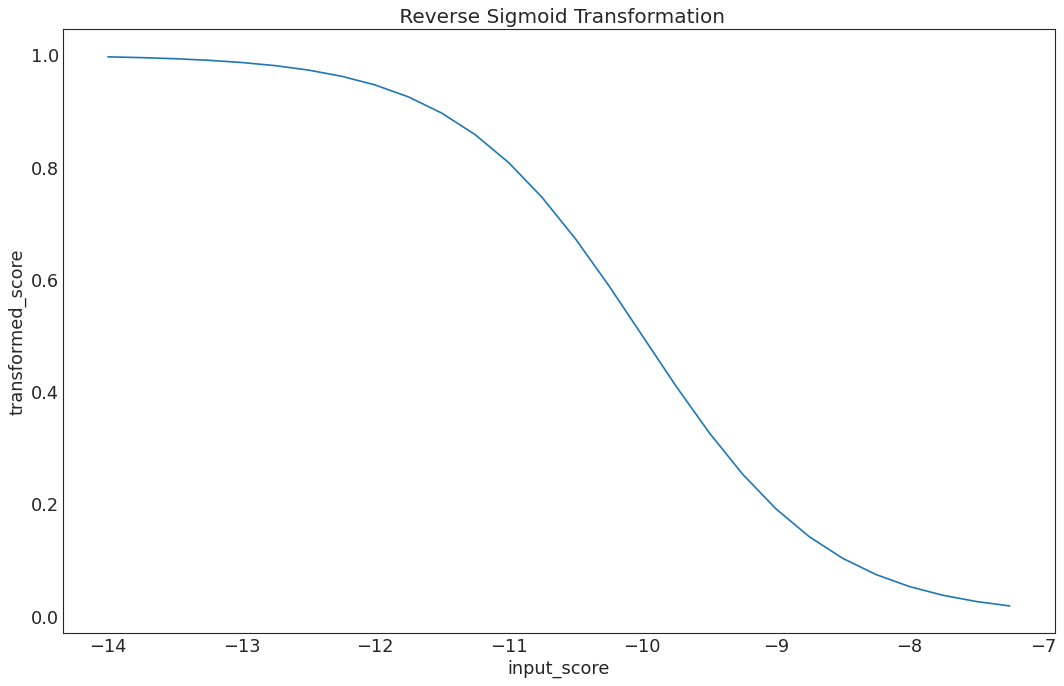

In [10]:
# sigmoid transformation
# ---------
values_list = np.arange(-14, -7, 0.25).tolist()
specific_parameters = {csp_enum.TRANSFORMATION: True,
                       csp_enum.LOW: -12,
                       csp_enum.HIGH: -8,
                       csp_enum.K: 0.25,
                       csp_enum.TRANSFORMATION_TYPE: tt_enum.REVERSE_SIGMOID}
transform_function = factory.get_transformation_function(specific_parameters)
transformed_scores = transform_function(predictions=values_list,
                                        parameters=specific_parameters)

# render the curve
render_curve(title=" Reverse Sigmoid Transformation", x=values_list, y=transformed_scores)

### How to specify the `DockStream` configuration file?
In principle, all options that are supported in a "normal" `DockStream` run (see above) are supported for usage with `REINVENT` as well, with a few notable exceptions. First, as we report only one value per ligand (and a "consensus score" is not yet supported), you should only use **one** embedding / pool and **one** backend (as in the example above). Second, the prospective ligands are not supplied via a file but from `stdin`, thus we will need to change the `input` part of the pool definition. Also, we might not want to write-out all conformers, so we will remove the `output` block entirely. The updated section then looks as follows:

```
{
    "pool_id": "Corina_pool",
    "type": "Corina",
    "parameters": {
        "removeHs": False
     },
     "input": {
         "standardize_smiles": False
     }
}
```

Finally, we will update the docking run as well. Typically, we want to see the docked poses per epoch and maybe also the scores and the SMILES in a well-tabulated format. Thus, we might retain the `output` block here, but as every epoch generates each of the files, it would overwrite it by default. If parameter `overwrite` is set to `False`, each consecutive write-out will be appended by a number, e.g. first epoch *poses.sdf* and *scores.csv*, second epoch *0001_poses.sdf* and *0001_scores.csv*, third epoch *0002_poses.sdf* and *0002_scores.csv* and so on.

```
{
    "backend": "AutoDockVina",
    "run_id": "AutoDockVina",
    "input_pools": ["Corina_pool"],
    ...
    "output": {
        "poses": { "poses_path": ligands_docked_path, "overwrite": False },
        "scores": { "scores_path": ligands_scores_path, "overwrite": False }
    }
}
```